<a href="https://colab.research.google.com/github/GauravSahani1417/Kaggle-Datasets/blob/master/Rock_Paper_Scissors_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

In [2]:
datasets, info = tfds.load(name='rock_paper_scissors', with_info=True, as_supervised=True, split=['train','test'])

In [3]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


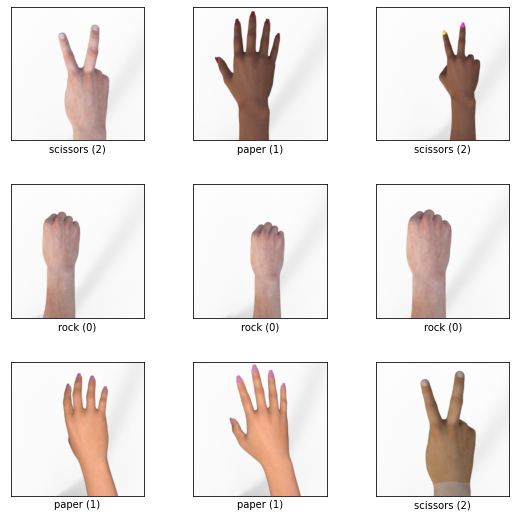

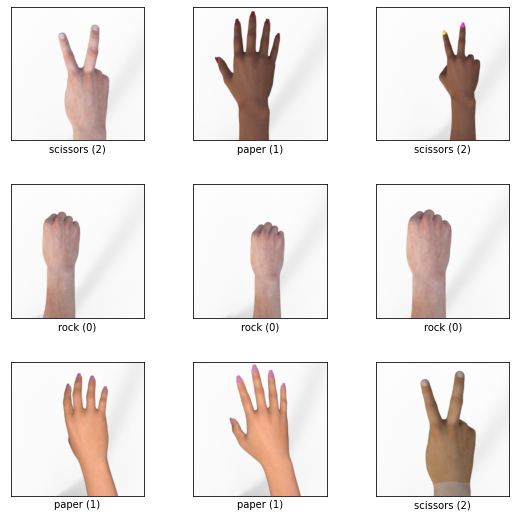

In [4]:
train, info_train = tfds.load(name='rock_paper_scissors', with_info=True, split='test')
tfds.show_examples(info_train,train)

In [5]:
dataset=datasets[0].concatenate(datasets[1])
dataset=dataset.shuffle(3000)

In [6]:
rsp_val=dataset.take(600)
rsp_test_temp=dataset.skip(600)
rsp_test=rsp_test_temp.take(400)
rsp_train=rsp_test_temp.skip(400)

In [7]:
len(list(rsp_train))

1892

In [8]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [9]:
def get_dataset(batch_size=64):
  train_dataset_scaled = rsp_train.map(scale).shuffle(1900).batch(batch_size)
  test_dataset_scaled =  rsp_test.map(scale).batch(batch_size)
  val_dataset_scaled =  rsp_val.map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [10]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [11]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [12]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [13]:
feature_extractor_layer.trainable = False

In [14]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [17]:
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [19]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_dataset, epochs=2, validation_data=val_dataset,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
30/30 [==============================] - 9s 292ms/step - loss: 0.7636 - acc: 0.8889 - val_loss: 0.7030 - val_acc: 0.9467
Epoch 2/2
30/30 [==============================] - 8s 265ms/step - loss: 0.6418 - acc: 0.9722 - val_loss: 0.6216 - val_acc: 0.9767


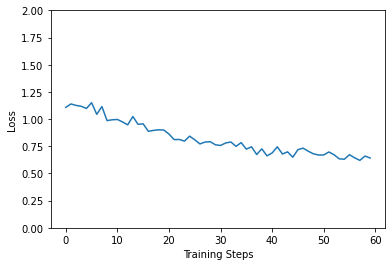

In [20]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

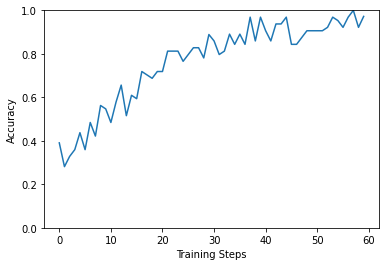

In [21]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [22]:

result=model.evaluate(test_dataset)

7/7 [==============================] - 0s 69ms/step - loss: 0.6124 - acc: 0.9850


[[0.01019867 0.10350972 0.88629156]]


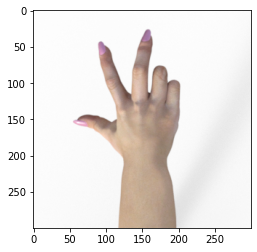

Actual Label: scissors
Predicted Label: scissors
[[0.4610297  0.5225114  0.01645893]]


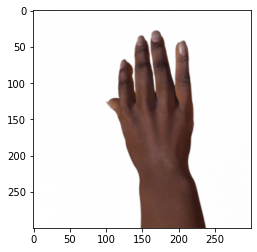

Actual Label: paper
Predicted Label: paper
[[0.04500887 0.89848787 0.0565033 ]]


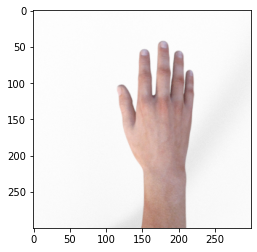

Actual Label: paper
Predicted Label: paper
[[0.02062705 0.09032615 0.8890468 ]]


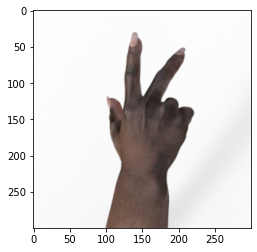

Actual Label: scissors
Predicted Label: scissors
[[0.03841539 0.04767957 0.913905  ]]


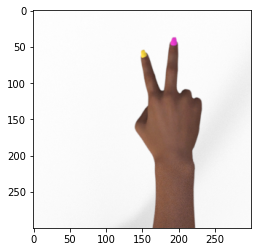

Actual Label: scissors
Predicted Label: scissors
[[0.9901804  0.00667179 0.00314788]]


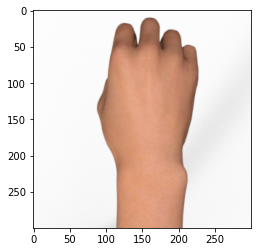

Actual Label: rock
Predicted Label: rock
[[0.9870293  0.0068     0.00617067]]


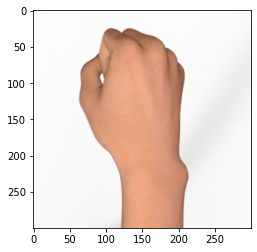

Actual Label: rock
Predicted Label: rock
[[0.02320413 0.03627267 0.94052315]]


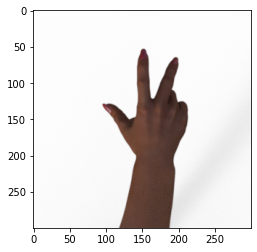

Actual Label: scissors
Predicted Label: scissors
[[0.9551322  0.03333303 0.01153472]]


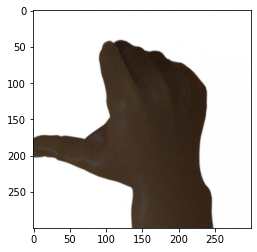

Actual Label: rock
Predicted Label: rock
[[0.00713658 0.02278077 0.97008264]]


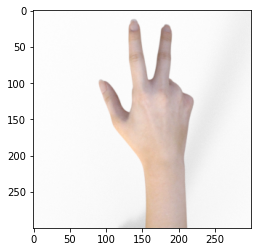

Actual Label: scissors
Predicted Label: scissors


In [23]:
for test_sample in rsp_test.take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])

In [24]:
np.argmax(model.predict(test_dataset),axis=1)

array([2, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2,
       2, 2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 2, 2, 1,
       1, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 1, 1, 0, 1,
       0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2, 1,
       2, 1, 0, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1,
       2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 0, 1,
       2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2,
       0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,